In [1]:
# general imports
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from braket.circuits import Circuit, circuit, Instruction
from braket.devices import LocalSimulator

from braket.tracking import Tracker

from scipy.special import iv
from scipy.linalg import expm, block_diag
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator

In [2]:
tracker = Tracker().start()
device = LocalSimulator()

In [3]:
N_sites = 4

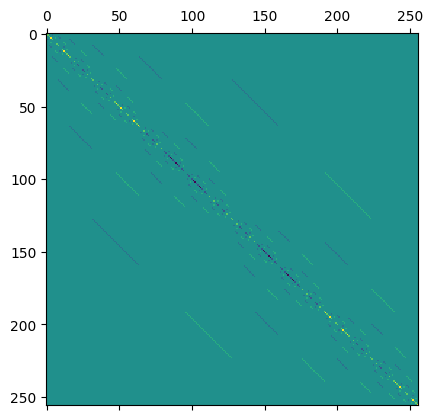

In [4]:
hubbard = fermi_hubbard(1, 4, 1, 4, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

plt.matshow(fh_matrix)

In [156]:
norm = np.linalg.norm(fh_matrix)
tau = np.pi/(4*norm)

In [152]:
def get_real_CDF(N_sites, t, U, precision):
    norm = np.linalg.norm(fh_matrix)
    tau = np.pi/(4*norm)
    
    Ndim = 2**(2*N_sites)
    energy, eigenstate= np.linalg.eig(tau*fh_matrix)

    hf_state = np.zeros(Ndim)
    hf_index = 0
    for i in range(N_sites):
        if i%2==0:
            hf_index += 2**(2*i)
        elif i%2!=0:
            hf_index += 2**(2*i+1)

    hf_state[hf_index] = 1
        

    energy=energy.real
    eigenstate[np.abs(eigenstate)<1e-10]=0
    eigenstate = np.array(eigenstate)

    prob_raw = np.zeros(Ndim)
    for i in range(Ndim):
        prob_raw[i] = np.abs(np.dot(hf_state,eigenstate[:,i]))**2
    prob = []
    ener = []
    for i,ele in enumerate(prob_raw):
        if ele!=0:
            prob.append(ele)
            ener.append(energy[i].real)

    x_list = np.linspace(-np.pi/3, np.pi/3, precision)
    CDF = np.zeros(len(x_list))

    for j,ener_ele in enumerate(ener):
        for i,x_ele in enumerate(x_list):
            if x_ele>ener_ele:
                CDF[i] += prob[j]

    return CDF

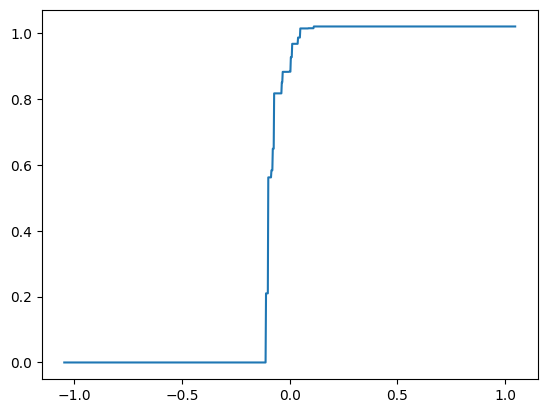

In [6]:
## Get Fermi-Hubbard Hamiltonian

def get_fh_Hamiltonian(t, U, N_sites):
    
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0,-1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    
    dim = 2**(2*N_sites)
    H = np.zeros((dim, dim))
    
    
    return None

In [7]:
## Get Trotterization Hamiltonian Evolution Gate:

def fh_evolution(N_sites, t, U, tau, j, step):
    
    qc = Circuit()
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.xx(2*i,2*i+1,theta)
            qc.yy(2*i,2*i+1,theta)

            qc.xx(2*i+N_sites,2*i+1+N_sites,theta)
            qc.yy(2*i+N_sites,2*i+1+N_sites,theta)
            
        for i in range((N_sites-1)//2):
            qc.xx(2*i+1,2*i+2,theta)
            qc.yy(2*i+1,2*i+2,theta)

            qc.xx(2*i+N_sites+1,2*i+2+N_sites,theta)
            qc.yy(2*i+N_sites+1,2*i+2+N_sites,theta)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.zz(i,i+N_sites,gamma)
    return qc

In [8]:
print(fh_evolution(4, 1, 2, 0.5, 1, 1))

T  : |   0    |   1    |            2             |   3    |        4        |
                                                                              
q0 : -XX(0.50)-YY(0.50)----------ZZ(0.50)-------------------------------------
      |        |                 |                                            
q1 : -XX(0.50)-YY(0.50)-XX(0.50)-|-----------------YY(0.50)-ZZ(0.50)----------
                        |        |                 |        |                 
q2 : -XX(0.50)-YY(0.50)-XX(0.50)-|-----------------YY(0.50)-|--------ZZ(0.50)-
      |        |                 |                          |        |        
q3 : -XX(0.50)-YY(0.50)----------|--------ZZ(0.50)----------|--------|--------
                                 |        |                 |        |        
q4 : -XX(0.50)-YY(0.50)----------ZZ(0.50)-|-----------------|--------|--------
      |        |                          |                 |        |        
q5 : -XX(0.50)-YY(0.50)-XX(0.50)----------|--------Y

In [9]:
def czz_gate(angle):
    qc = Circuit()
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    
    return qc

def cxx_gate(angle):
    qc = Circuit()
    qc.h([1,2])
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.h([1,2])
    return qc

def cyy_gate(angle):
    qc = Circuit()
    qc.rx([1,2],pi/2)
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.rx([1,2],-pi/2)
    
    return qc

In [10]:
print(czz_gate(.1))

T  : |0|     1     |2|
                      
q0 : ---C-------------
        |             
q1 : -C-|-----------C-
      | |           | 
q2 : -X-PHASE(0.10)-X-

T  : |0|     1     |2|


In [29]:
## Get circuit for Hadamard Test

def get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real'):
    
    num_qubits = 2*N_sites+1
    qc = Circuit()
    
    qc.h(0)
    
    ## State Initialization
    for i in range(N_sites):
        if i%2!=0:
            qc.x(i+1)
        else:
            qc.x(i+1+N_sites)
            
    ## Control-Evolution Gate
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step    
        for i in range(N_sites//2):
            #qc.cxx(num_qubits-1,[2*i,2*i+1],theta)
            qc.add_circuit(cxx_gate(theta),[0, 2*i+1, 2*i+2])
            
            #qc.cyy(num_qubits-1,[2*i,2*i+1],theta)
            qc.add_circuit(cyy_gate(theta),[0, 2*i+1, 2*i+2])
            
            #qc.cxx(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
            qc.add_circuit(cxx_gate(theta),[0, 2*i+1+N_sites, 2*i+2+N_sites])
            
            #qc.cyy(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
            qc.add_circuit(cyy_gate(theta),[0, 2*i+1+N_sites, 2*i+2+N_sites])

            
            
        for i in range((N_sites-1)//2):
            #qc.cxx(num_qubits-1,[2*i+1,2*i+2],theta)
            qc.add_circuit(cxx_gate(theta),[0, 2*i+2, 2*i+3])
            
            #qc.cyy(num_qubits-1,[2*i+1,2*i+2],theta)
            qc.add_circuit(cyy_gate(theta),[0, 2*i+2, 2*i+3])
            
            qc.add_circuit(cxx_gate(theta),[0, 2*i+2+N_sites, 2*i+3+N_sites])
            qc.add_circuit(cyy_gate(theta),[0, 2*i+2+N_sites, 2*i+3+N_sites])
        
        ## Potential terms
        gamma = tau*U*j/(2*step)
        for i in range(N_sites):
            qc.add_circuit(czz_gate(gamma),[0, i+1, i+1+N_sites])
    
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.si(0)
    
    qc.h(0)
    
    qc.probability(target=0)
    return qc


In [62]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real'):
    num_qubits = 2*N_sites+2
    qc = Circuit()

    qc.h([0,1])

    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    ## Control-UI gate
    for i in range(N_sites):
        if i%2!=0:
            qc.cnot(0,i+2)
        else:
            qc.cnot(0, i+2+N_sites)

    ## Control-UR gate, but pass

    ## evolution
    qc.add_circuit(fh_evolution(N_sites, t, U, tau, j, step), range(2,num_qubits))

    ## Control-UI_dagger gate
    for i in range(N_sites):
        if i%2!=0:
            qc.cnot(1,i+2)
        else:
            qc.cnot(1, i+2+N_sites)

    qc.h([0,1])

    qc.probability(target=range(num_qubits))
    return qc

In [66]:
job = device.run(get_new_Hadamard_circuit(4, 1, 4, 0.5, 1, 1),shots=1000)
res = job.result()

In [67]:
res

GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='d338228d-5558-4045-8492-cb00fccfaa4a', shots=1000, deviceId='braket_sv', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='OPENQASM 3.0;\nqubit[10] q;\nh q[0];\nh q[1];\ncnot q[0], q[6];\ncnot q[0], q[3];\ncnot q[0], q[8];\ncnot q[0], q[5];\nxx(0.5) q[2], q[3];\nyy(0.5) q[2], q[3];\nxx(0.5) q[6], q[7];\nyy(0.5) q[6], q[7];\nxx(0.5) q[4], q[5];\nyy(0.5) q[4], q[5];\nxx(0.5) q[8], q[9];\nyy(0.5) q[8], q[9];\nxx(0.5) q[3], q[4];\nyy(0.5) q[3], q[4];\nxx(0.5) q[7], q[8];\nyy(0.5) q[7], q[8];\nzz(1.0) q[2], q[6];\nzz(1.0) q[3], q[7];\nzz(1.0) q[4], q[8];\nzz(1.0) q[5], q[9];\ncnot q[1], q[6];\ncnot q[1], q[3];\ncnot q[1], q[8];\ncnot q[1], q[5];\nh q[0];\nh q[

In [53]:
A = res.measurement_probabilities

A['0000000000']

0.042

In [48]:
#print(get_Hadamard_circuit(N_sites=4, t=1, U=4, tau=.1, j=1, step=1))

In [78]:
def get_new_Z(N_sites, t, U, tau, j, step, shots):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='imag')

    device = LocalSimulator()
    job_real = device.run(qc_real, shots=shots)
    job_imag = device.run(qc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()

    probs_real = res_real.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_real.keys():
        p00 = probs_real['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_real.keys():
        p01 = probs_real['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_real.keys():
        p10 = probs_real['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_real.keys():
        p11 = probs_real['11'+'0'*2*N_sites]
        
    X = p00+p11-p01-p10 

    probs_imag = res_imag.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_imag.keys():
        p00 = probs_imag['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_imag.keys():
        p01 = probs_imag['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_imag.keys():
        p10 = probs_imag['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_imag.keys():
        p11 = probs_imag['11'+'0'*2*N_sites]
    
    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

In [54]:
p00, p01, p10, p11 = 0,0,0,0

In [36]:
B = device.run(A, shots=1000)

In [37]:
res = B.result()


In [16]:
res.measurements

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
def get_F(beta, j):
    
    F = -1j*np.sqrt(beta/(2*pi))*np.exp(-beta)*(iv(j,beta)+iv(j+1,beta))/(2*j+1)
    #print(np.sqrt(beta/(2*pi)))
    #print((iv(j,beta)+iv(j+1,beta))/(2*j+1))
    return F

In [18]:
def get_F_coefs(d, beta):
    F_list = np.zeros(d+1,dtype='complex128')
    
    for j in range(d):
        F_list[j] = get_F(beta, j)
    
    F_list[d] = -1j*np.sqrt(.5*beta/pi) * np.exp(-beta) * iv(d,beta)/(2*d+1)
    
    return F_list

In [19]:
def get_approx_step_function(d, beta):

    x_list = np.linspace(-pi,pi,10000)
    F_coefs = get_F_coefs(d, beta)

    F_approx = 0.5*np.ones(len(x_list))

    for j, F in enumerate(F_coefs):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    
    return F_approx.real


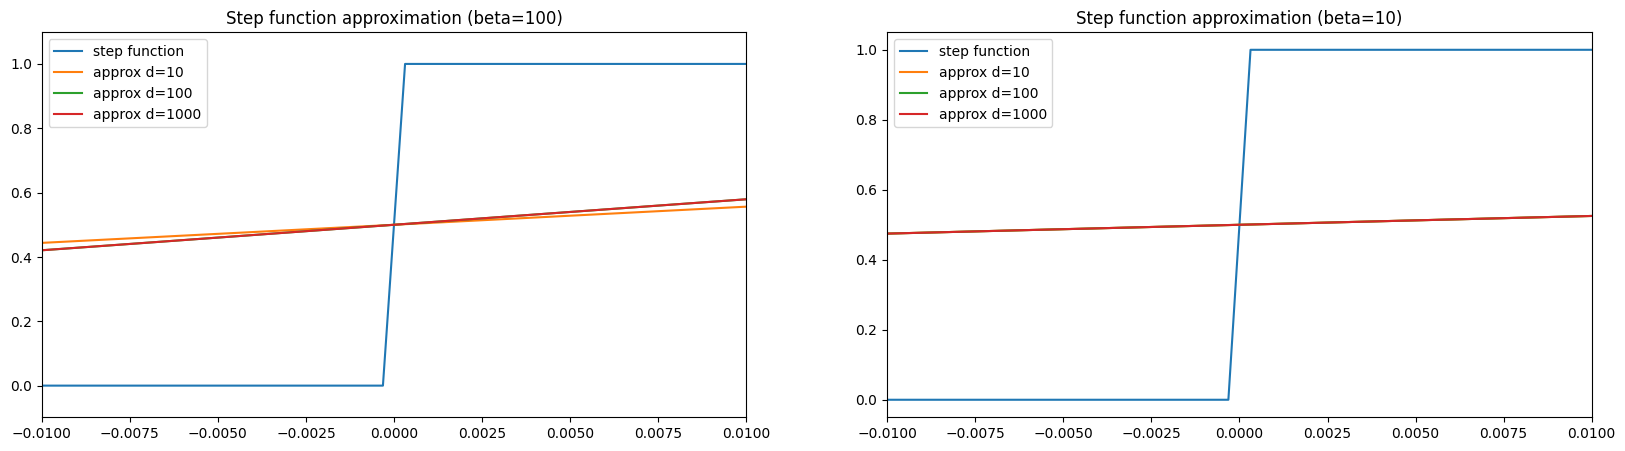

In [21]:
x_list = np.linspace(-pi,pi,10000)
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[0].plot(x_list,get_approx_step_function(d=10,beta=100),label='approx d=10')
ax[0].plot(x_list,get_approx_step_function(d=100,beta=100),label='approx d=100')
ax[0].plot(x_list,get_approx_step_function(d=1000,beta=100),label='approx d=1000')
ax[0].set_title('Step function approximation (beta=100)')
ax[0].legend()
ax[0].set_xlim([-.01,.01])

ax[1].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[1].plot(x_list,get_approx_step_function(d=10,beta=10),label='approx d=10')
ax[1].plot(x_list,get_approx_step_function(d=100,beta=10),label='approx d=100')
ax[1].plot(x_list,get_approx_step_function(d=1000,beta=10),label='approx d=1000')
ax[1].set_title('Step function approximation (beta=10)')
ax[1].set_xlim([-.01,.01])
ax[1].legend()

In [39]:
def get_Z(N_sites, t, U, tau, j, step, shots):
    
    qc_real = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real')
    qc_imag = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='imag')
    
    device = LocalSimulator()
    job_real = device.run(qc_real, shots=shots)
    job_imag = device.run(qc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()
    prob_real = res_real.values[0]
    prob_imag = res_imag.values[0]
    
    Z = (prob_real[0]-prob_real[1])+1j*(prob_imag[0]-prob_imag[1])
    
    return Z

In [119]:
def get_Z_list(d, N_sites, t, U, tau, step, shots_per_run): ## shots_per_run should be replaced
    
    Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_per_run) for j in range(d+1)]
    
    return Z_list

In [139]:
#get_Z_list(d=20,N_sites=4, t=1, U=4, tau=0.0185533,step=1, shots_per_run=1000)
get_new_Z(4, 1, 4, tau, 5, 1, 10000)

(0.9034036427399487+0.3627028787922577j)

In [77]:
if (('00'+'0'*2*4) in res.measurement_probabilities.keys()):
    print(A)

['1', '2']


In [74]:
A = ['1','2']

if '1' in A:
    print(1)

1


In [25]:
get_Z(4, 1, 4, .5, 0, 1, 0)

(0.9999999999999958+0j)

\begin{equation}
ACDF(x) = 0.5+\sum^d_{j=0} F_j e^{i(2j+1)x} Z_j
\end{equation}


In [145]:
def Assembly_ACDF(Z_list, F_list, precision):
    
    ACDF = .5*np.ones(precision)
    x_list = np.linspace(-pi,pi,precision)
    d = len(F_list)-1
    
    for j in range(d+1):
        ACDF = ACDF + F_list[j]*Z_list[j]*np.exp(1j*(2*j+1)*x_list) - F_list[j]*Z_list[j].conj()*np.exp(-1j*(2*j+1)*x_list)
        #ACDF = ACDF + F_list[j]*Z_list[j]*2j*np.sin((2*j+1)*x_list)
                                                                              
    return ACDF

In [151]:
Z_list

[(0.9951810883379294+0.06799942216323716j),
 (0.980185058909807+0.22369168578643694j),
 (0.9174336026462941+0.35187882109533375j),
 (0.8185693588116647+0.4721155418058808j),
 (0.7168688150128095+0.5838718198904022j),
 (0.6028762888832927+0.6487412275339902j),
 (0.46043438043652585+0.6702195023363857j),
 (0.3471577938516103+0.7138127949035957j),
 (0.22261179448003907+0.6965612887308459j),
 (0.11256211597230908+0.6603290468000301j),
 (0.0063585699572429304+0.636526644051998j),
 (-0.08412887443471233+0.563425782589285j),
 (-0.1448953530313768+0.48851511406497206j),
 (-0.1759057181026219+0.40739359143069614j),
 (-0.21840405865944157+0.3289968193783691j),
 (-0.24359868490363892+0.2541449993866053j),
 (-0.2290310786384351+0.20057010000923603j),
 (-0.20856313167157509+0.143799930832199j),
 (-0.1864723865447864+0.07902941892923004j),
 (-0.17482377609131028+0.04373931084476996j),
 (-0.1583702729952914+0.024288611145902722j),
 (-0.12920358205054613-0.013013623066148148j),
 (-0.08237728437434433-

In [157]:
Z_list = get_Z_list(50, 4, 1, 4, tau, 1, 10000)
F_list = get_F_coefs(d=50, beta=50)
ACDF = Assembly_ACDF(Z_list, F_list, 10000)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-1.0471975511965976, 1.0471975511965976)

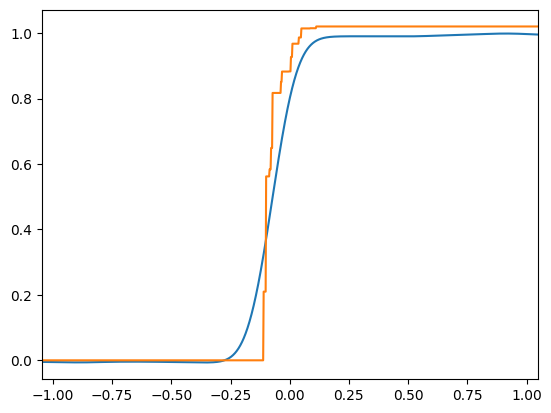

In [160]:
plt.plot(np.linspace(-pi,pi,10000), ACDF)
plt.plot(np.linspace(-np.pi/3, np.pi/3, 1000), get_real_CDF(4,1,4,precision=1000), label='CDF')
plt.xlim([-pi/3, pi/3])